In [ ]:
#%matplotlib widget

# Dependecies

```shell
pip install librosa pydub scipy numpy matplotlib pretty_midi mingus -U
```


In [59]:
# IMPORTS
import librosa.display
from pydub import AudioSegment
import os
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython as ip
import pretty_midi
import random
import mingus.core.scales as scales
import mingus.core.chords as chords
import ipywidgets as widgets
from IPython.display import display

In [60]:
## PARAMETERS
# FILES
TEST_WAV = "test.wav"
OUT_WAV = "out.wav"
OUT_MIDI = "out.mid"
OUT_MIX = "out_mix.wav"
OUT_MIX_MP3 = "out_mix.mp3"

# FEATURES
FRAME_LENGTH = 1000
TOP_DB = 15
FRAME_LENGTH_UI = widgets.IntSlider(value=1000, min=1, max=10000)
TOP_DB_UI = widgets.IntSlider(value=15, min=0, max=60)


# MIDI
SCALE_KEY = 'E'
CHORDS_KEY = 'E' # this can be upper or lower case
scale_to_use = scales.Major
SCALE = scale_to_use(SCALE_KEY)
CHORDS = chords.triads(SCALE_KEY)
INSTRUMENT = 'Marimba'
INSTRUMENT_CH = 'Acoustic Grand Piano'
SF2_PATH = "/usr/share/soundfonts/FluidR3_GM.sf2"
CHORDS_HUMANIZER = 0.01
CHORD_MELO_PROBABILITY = 0.4
CHORD_NON_MELO_PROBABILITY = 0.2
NOTES_OCTAVES = ['3', '4', '5']
CHORD_OCTAVES = ['3', '4']

# SYNTH WAVS
IN_GAIN = 0.5
OUT_GAIN = 1 

In [61]:
# LOAD AUDIO
in_arr, sr = librosa.load(TEST_WAV, mono=True)

In [62]:
#Check if marks are correct
def calculate_features(top_db, frame_legth):
    features = librosa.effects.split(y=in_arr, frame_length=frame_legth, top_db=top_db)
    marks = np.concatenate(features) / sr
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.vlines(marks , -1, 1, colors='red')
    librosa.display.waveshow(in_arr, sr=sr, ax=ax)
    
out_widget = widgets.interactive_output(calculate_features, {'top_db': TOP_DB_UI, 'frame_legth': FRAME_LENGTH_UI})
widgets.VBox([TOP_DB_UI, FRAME_LENGTH_UI, out_widget])

In [63]:
# GET FEATURES USING PRE TESTED VALUES
features = librosa.effects.split(y=in_arr, frame_length=FRAME_LENGTH_UI.value, top_db=TOP_DB_UI.value)

In [68]:
# BUILD MIDI
pm = pretty_midi.PrettyMIDI()
instrument_program = pretty_midi.instrument_name_to_program(INSTRUMENT)
instrument = pretty_midi.Instrument(program=instrument_program)
instrument_program_ch = pretty_midi.instrument_name_to_program(INSTRUMENT_CH)
instrument_ch = pretty_midi.Instrument(program=instrument_program_ch)

def add_random_chord(instrument, start, end):
    if random.random() < CHORD_MELO_PROBABILITY:
        RAND_CHORD = random.choices(CHORDS)
        for n in RAND_CHORD[0]:
            velocity = random.randint(30, 60)
            start += (random.random() * CHORDS_HUMANIZER)
            end += (random.random() * CHORDS_HUMANIZER)
            note_number = pretty_midi.note_name_to_number(n + random.choice(CHORD_OCTAVES))
            note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
            instrument.notes.append(note)

def add_random_chord_between(instrument, start, end):
    if random.random() < CHORD_NON_MELO_PROBABILITY:
        RAND_CHORD = random.choices(CHORDS)
        start += random.random()
        end +=  random.random()
        for n in RAND_CHORD[0]:
            velocity = random.randint(30, 40)
            start += (random.random() * CHORDS_HUMANIZER)
            end += (random.random() * CHORDS_HUMANIZER)
            note_number = pretty_midi.note_name_to_number(n + random.choice(CHORD_OCTAVES))
            note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=end, end=end)
            instrument.notes.append(note)

def add_random_note(instrument, velocity, start, end):
    note_name = random.choice(SCALE.ascending()) + random.choice(NOTES_OCTAVES)
    note_number = pretty_midi.note_name_to_number(note_name)
    note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
    instrument.notes.append(note)
            
for start, end in features:
    start_f = float(start / sr) 
    end_f = float(end / sr )
    velocity = int(np.sqrt(np.mean(in_arr[start:end] ** 2))*127) + 50 # map RMS to vel +50 (?)
    add_random_note(instrument, velocity, start_f, end_f)
    add_random_chord(instrument_ch, start_f, end_f)
    add_random_chord_between(instrument_ch, start_f, end_f)

pm.instruments.append(instrument)
pm.instruments.append(instrument_ch)

In [69]:
# OUTPUT 
# uncomment to generate midi file
# pm.write(OUT_MIDI)
synth_midi = pm.fluidsynth(fs=sr, sf2_path=SF2_PATH)
scipy.io.wavfile.write(OUT_WAV, data=synth_midi, rate=sr)

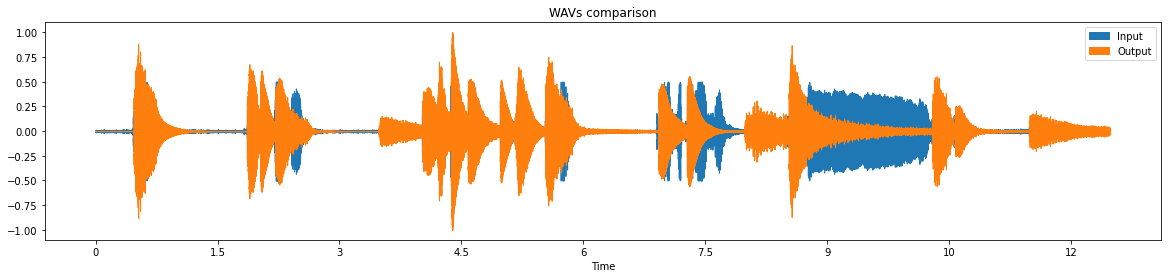

In [70]:
# PLOT INPUT AND OUTPUT TO COMPARE
in_arr, sr1 = librosa.load(TEST_WAV, mono=True)
out_arr, sr2 = librosa.load(OUT_WAV, mono=True)

fig, ax = plt.subplots(sharex=True, figsize=(20, 4))
img_input = librosa.display.waveshow(in_arr*(IN_GAIN), sr=sr1, ax=ax, label="Input")
img_output = librosa.display.waveshow(out_arr*(OUT_GAIN), sr=sr1, ax=ax, label="Output")
ax.set(title='WAVs comparison')
ax.legend()

In [71]:
# MERGE
# PAD to be same length
in_arr_pad = in_arr
out_arr_pad = out_arr

if len(in_arr) > len(out_arr):
    out_arr_pad = np.pad(out_arr, (0, len(in_arr)-len(out_arr)), 'constant', constant_values=(0, 0))
elif len(in_arr) < len(out_arr):
    in_arr_pad = np.pad(in_arr, (0, len(out_arr)-len(in_arr)), 'constant', constant_values=(0, 0))

out_mix_array = ((in_arr_pad*IN_GAIN) + (out_arr_pad*OUT_GAIN))/2
out_mix_sr = int((sr1+sr2)/2)

# REPRODUCE
ip.display.Audio(out_mix_array, rate=out_mix_sr)

In [349]:
# OUTPUT MIX
scipy.io.wavfile.write(OUT_MIX, data=out_mix_array, rate=out_mix_sr)
wav_audio = AudioSegment.from_wav(OUT_MIX)
wav_audio.export(OUT_MIX_MP3, format="mp3", bitrate="192k")

<_io.BufferedRandom name='out_mix.mp3'>